# A zero-entropy classical shadow reconstruction of density state operators: **ibm_brisbane** Results

https://arxiv.org/abs/2408.17317

In [2]:
import numpy as np
from scipy.linalg import sqrtm, logm
import networkx as nx
import os
import matplotlib.pyplot as plt

from qiskit_ibm_provider import IBMProvider
from qiskit_aer import Aer
from qiskit import QuantumCircuit, ClassicalRegister, transpile
from qiskit.quantum_info import DensityMatrix, partial_trace
from qiskit.circuit.library import EfficientSU2

zero_state = np.array([[1,0],[0,0]], dtype=complex)
one_state = np.array([[0,0],[0,1]], dtype=complex)
phase_z = np.array([[1,0],[0,-1j]], dtype=complex)
hadamard = (1/np.sqrt(2)) * np.array([[1,1],[1,-1]], dtype=complex)
identity = np.eye(2, dtype=complex)
unitaries = [hadamard, hadamard @ phase_z , identity]


/var/folders/76/d4kyjysx1xgdrrs6zzs63s180000gn/T/ipykernel_50147/2756490596.py:7: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider


In [2]:
provider = IBMProvider()

In [3]:
backends = {}
backends["ideal"] = Aer.get_backend("qasm_simulator")
backends["ibm_brisbane"] = provider.get_backend("ibm_brisbane")

In [3]:
def classical_shadows_circuits(circuit, unitary_ids, backend):
    """
    Input:
        circuit: Qiskit circuit that one wants to know the density matrix
        unitary_ids: Random basis to measure the circuit to recover the Classical Shadows information
        backend: Where the circuit will run (Important to transpile in terms of the backend layout) 
    Return: Circuit with the classical shadows basis.
    """
    num_shadow = len(unitary_ids)
    num_qubits = circuit.num_qubits
    qcs = []
    for shadow_i in range(num_shadow):
        qc_g = QuantumCircuit(num_qubits)
        for i in range(num_qubits):
            if unitary_ids[shadow_i, i] == 0:
                qc_g.h(i)
            elif unitary_ids[shadow_i, i] == 1:
                qc_g.sdg(i)
                qc_g.h(i) 
            elif unitary_ids[shadow_i, i] == 2:
                pass
            else:
                raise ValueError("This is not a valid pauli string")
        qc_g = transpile(qc_g, backend, optimization_level=0)
        qc = circuit.compose(qc_g, range(num_qubits))
        qc.add_register(ClassicalRegister(num_qubits))
        qc.measure(range(num_qubits), reversed(range(num_qubits)))
        qcs.append(qc)
        if not shadow_i % (num_shadow//10):
            print(f" Shadows: {shadow_i}")
    return qcs

def qaoa_maxcut(G, gammas, betas):
    p = len(gammas) 
    nodes = G.nodes()
    num_nodes =len(nodes)
    weights = [G[i][j]["weight"] for i,j in G.edges()]
    max_weight = max(weights)
    qc = QuantumCircuit(num_nodes)
    qc.h(nodes)
    for pi in range(p):
        for i, j in G.edges():
            qc.cx(i, j)
            qc.rz(2 * gammas[pi] * G[i][j]["weight"]/max_weight,j)
            qc.cx(i, j)
        qc.rx(-2 * betas[pi], nodes)
    return qc

def arn_circuits(qcs, n_shadow, backend, cases, max_circs=300):
    arn = []
    list_qc = np.concatenate((np.arange(0, n_shadow, max_circs),[n_shadow]))
    for i in cases:
        arn.append(backend.run(qcs[list_qc[i]:list_qc[i+1]], shots=1).job_id())
        print(f"------Completed {i+1} from {len(list_qc)-1}-----")
    return arn

def retrieved_info(arn, n_shadow, provider):
    snapshots = []
    list_qc = np.concatenate((np.arange(0, n_shadow, 300),[n_shadow]))
    for i in range(len(list_qc)-1):
        snapshots += [list(i.keys())[0] for i in provider.backend.retrieve_job(job_id=arn[i]).result().get_counts()]
        print(f"------Completed {i+1} from {len(list_qc)-1}-----")
    return snapshots

def snapshot_state(b_list, obs_list, list_qubits):
    num_qubits = len(b_list)
    if len(list_qubits) == 0:
        list_qubits = range(num_qubits)
    # computational basis state
    rho_snapshot = [1]
    for i in reversed(list_qubits):
        state = zero_state if b_list[i] == "0" else one_state
        U = unitaries[obs_list[i]] 
        local_rho = 3 * (U.conj().T @ state @ U) - identity # Eq. S44 classical shadows paper
        rho_snapshot = np.kron(rho_snapshot, local_rho)
    return rho_snapshot

def shadow_state_reconstruction(shadow, basis, list_qubits):
    num_snapshots = len(shadow)
    num_qubits = len(list_qubits)
    
    shadow_rho = np.zeros((2 ** num_qubits, 2 ** num_qubits), dtype=complex)
    for i in range(num_snapshots):
        shadow_rho += snapshot_state(shadow[i], basis[i], list_qubits)
    
    return shadow_rho / num_snapshots

def zecs(p):
    """
    Find the singular vector corresponding to the smallest singular value 
    (which can approximate the zero energy coherent state, ZEC).

    Parameters:
    p (numpy.ndarray): A density matrix or any square matrix.

    Returns:
    numpy.ndarray: The singular vector corresponding to the smallest singular value.
    """
    
    # Step 1: Perform Singular Value Decomposition (SVD) of the input matrix p.
    # np.linalg.svd returns three matrices: U and singular values (S).
    U, S, _ = np.linalg.svd(p, hermitian=True)
    
    # Step 2: Extract the right-singular vector (fist column of U) corresponding to the largest singular value.
    # This state vector contains the largest overlap with the ideal state vector that described the given circuit.
    best_sv = U[:,0].reshape(-1, 1)  # Reshaping into a column vector.

    # Step 3: Return the singular vector corresponding to the largest singular value.
    return best_sv

def fidelity(rho_ideal, rho_real):
    """
    Calculate the fidelity between two quantum states represented by density matrices.
    
    Fidelity is a measure of how close two quantum states are, where a value of 1 means 
    the states are identical, and a value of 0 means they are orthogonal (completely different).

    Parameters:
    rho_ideal (numpy.ndarray): The ideal density matrix (target quantum state).
    rho_real (numpy.ndarray): The actual density matrix (quantum state to compare to the ideal).

    Returns:
    float: The fidelity between rho_ideal and rho_real, a value between 0 and 1.
    """
    
    # Step 1: Compute the matrix square root of the real density matrix (rho_real)
    # The matrix square root operation finds a matrix such that s_rho_real * s_rho_real = rho_real
    s_rho_real = sqrtm(rho_real)

    # Step 2: Compute the intermediate matrix: s_rho_real * rho_ideal * s_rho_real
    # This is part of the Uhlmann's fidelity formula: sqrt(sqrt(rho_real) * rho_ideal * sqrt(rho_real))
    intermediate_matrix = s_rho_real @ rho_ideal @ s_rho_real

    # Step 3: Take the matrix square root of the intermediate result to continue the fidelity calculation
    # sqrtm computes the square root of the matrix
    sqrt_intermediate_matrix = sqrtm(intermediate_matrix)

    # Step 4: The fidelity is the squared trace of the resulting matrix.
    # .trace() computes the sum of the diagonal elements of the matrix.
    # .real ensures we only take the real part of the trace (since small imaginary values might arise from numerical errors).
    fidelity_value = (sqrt_intermediate_matrix.trace().real) ** 2

    # Step 5: Return the fidelity value (a number between 0 and 1)
    return fidelity_value

def entropy(p):
    """
    Calculate the von Neumann entropy of a density matrix.

    The von Neumann entropy is a measure of the quantum state's uncertainty or mixedness.
    It is given by the formula: S(p) = -Tr(p * log(p)), where 'log' is the matrix logarithm,
    and Tr() is the trace operation (sum of diagonal elements).

    Parameters:
    p (numpy.ndarray): The density matrix, a square matrix that represents the quantum state.

    Returns:
    float: The von Neumann entropy of the quantum state, a non-negative real number.
    """
    
    # Step 1: Compute the matrix logarithm of the density matrix p.
    # logm(p) computes the logarithm of a matrix, which is needed in the von Neumann entropy formula.
    log_p = logm(p)

    # Step 2: Compute the product of the density matrix p and its logarithm.
    # This gives us p * log(p), which will be used to compute the entropy.
    entropy_matrix = p @ log_p

    # Step 3: Compute the trace of the product matrix.
    # The trace is the sum of the diagonal elements of the matrix.
    # .real ensures that we only take the real part of the trace, to avoid numerical artifacts.
    entropy_value = (-entropy_matrix).trace().real

    # Step 4: Return the von Neumann entropy.
    return entropy_value

def trace_distance(p1, p2):
    """
    Calculate the trace distance between two density matrices.
    
    The trace distance is a measure of the distinguishability between two quantum states.
    It is defined as D(p1, p2) = 0.5 * Tr(|p1 - p2|), where |A| represents the square root
    of the positive semidefinite matrix A^† A.
    
    Args:
        p1 (numpy.ndarray): The first density matrix.
        p2 (numpy.ndarray): The second density matrix.
    
    Returns:
        float: The trace distance between p1 and p2.
    """
    
    # Step 1: Compute the difference between the two density matrices
    R = p1 - p2
    
    # Step 2: Compute the square root of the matrix R^† R (R conjugate transpose times R)
    # This is equivalent to taking the absolute value of the operator.
    abs_R = sqrtm(R.conj().T @ R)
    
    # Step 3: Compute the trace of the absolute value matrix
    trace_abs_R = np.trace(abs_R).real  # Take only the real part
    
    # Step 4: Return half of the trace as per the definition of trace distance
    return 0.5 * trace_abs_R

In [4]:
list_2q = [[13, 12], [11, 10], [9, 8], [7, 6], [5, 4], [3, 2], [1, 0], [14, 18],
              [19, 20], [21, 22], [23, 24], [25, 26], [27, 28], [29, 30], [31, 32], [36, 51],
              [50, 49], [48, 47], [46, 45], [44, 43], [42, 41], [40, 39], [38, 37], [52, 56],
              [57, 58], [59, 60], [61, 62], [63, 64], [65, 66], [67, 68], [69, 70], [74, 89],
              [88, 87], [86, 85], [84, 83], [82, 81], [80, 79], [78, 77], [76, 75], [90, 94],
              [95, 96], [97, 98], [99, 100], [101, 102], [103, 104], [105, 106], [107, 108],
              [112, 126], [125, 124], [123, 122], [121, 120], [119, 118], [117, 116], [115, 114]]

In [5]:
# QAOA 2-qubit problem
G = nx.Graph()
G.add_nodes_from(range(2))
G.add_weighted_edges_from([[0, 1, 0.5]])  

# 1. Collecting the samples (You can skip this step and load the data from previous simulations in 2)

In [10]:
results = {}
backend_name = "ibm_brisbane"
n_qubits = backends[backend_name].num_qubits
results["shots"] = 6000
results["list_2q"] = list_2q
reps = 10 # Number of the EfficientSU2 circuit repetition


qc = QuantumCircuit(n_qubits)
params = []
results["pideal"] = {}
for i in results["2q_list"]:
    qc_su2 = EfficientSU2(len(i), reps=reps, parameter_prefix=f"θ{i}")
    params_i = np.pi * np.random.rand(qc_su2.num_parameters)
    qc_su2 = qc_su2.assign_parameters(params_i)
    qc = qc.compose(qc_su2, i)
    params.append(params_i)
    results["pideal"][tuple(i)] = np.array(DensityMatrix(qc_su2))

qc = transpile(qc, backends[backend_name], optimization_level=0)
results["depth"] = qc.depth()
results["operations"] = qc.count_ops()    
results["random_unitaries"] = np.random.randint(0, 3, size=(results["shots"], n_qubits))
results["arn"] = []
qcs = classical_shadows_circuits(qc, results["random_unitaries"], backends[backend_name])

 Shadows: 0
 Shadows: 600
 Shadows: 1200
 Shadows: 1800
 Shadows: 2400
 Shadows: 3000
 Shadows: 3600
 Shadows: 4200
 Shadows: 4800
 Shadows: 5400


In [ ]:
os.makedirs(f"./Data/{backend_name}/", exist_ok=True)

cases = np.array([0,1,2]) # Open plan only allows to submit 3 jobs at once (Each with 300 circuits)
arn = arn_circuits(qcs, results["shots"], backends[backend_name], cases=cases)
results["arn"] += arn
np.save(f"./Data/{backend_name}/shadows_EfficientSU2_{reps}.npy", results)

In [23]:
backend_name = "ibm_brisbane"
reps = 10
results = np.load(f"./Data/{backend_name}/shadows_EfficientSU2_{reps}.npy", allow_pickle=True).item()
results["snapshots"] = retrieved_info(results["arn"], results["shots"], provider)

------Completed 1 from 20-----
------Completed 2 from 20-----
------Completed 3 from 20-----
------Completed 4 from 20-----
------Completed 5 from 20-----
------Completed 6 from 20-----
------Completed 7 from 20-----
------Completed 8 from 20-----
------Completed 9 from 20-----
------Completed 10 from 20-----
------Completed 11 from 20-----
------Completed 12 from 20-----
------Completed 13 from 20-----
------Completed 14 from 20-----
------Completed 15 from 20-----
------Completed 16 from 20-----
------Completed 17 from 20-----
------Completed 18 from 20-----
------Completed 19 from 20-----
------Completed 20 from 20-----


# 2. Postprocessing the information. Density state reconstruction

## Classical Shadow

Classical shadow is a method for reconstructing an approximate classical description of a quantum system using a small number of measurements [1](https://arxiv.org/abs/2002.08953). To reconstruct an $n$-qubit quantum state $\rho$ using N snapshots, random unitary gates $U_i$ are applied to $\rho$

\begin{equation}
\rho\rightarrow U_i\rho U_i^\dagger,\tag{1}
\end{equation}
and measured in the computational basis. This results in a bitstrings $|b\rangle \in \{0,1\}^n$ and is modeled by the quantum channel 
\begin{equation}
\mathbb{E}\left[ U_i^\dagger|b_i\rangle \langle b_i|U_i\right] = \mathcal{M}(\rho_i), \tag{2}
\end{equation}
where the operator $\mathcal{M}$ depends on the set of random unitary transformations $U_i$. A classical snapshot $\rho_i$ of $\rho$ can be constructed using the inverted operator such that
\begin{equation}
\rho_i = \mathcal{M}^{-1}(U_i^\dagger|b_i\rangle \langle b_i|U_i),\tag{3}
\end{equation}
where $\mathcal{M}^{-1}(X) = (2^n + 1)X - \mathrm{I}$. This is not completely positive, but the collection of $N$ snapshots is expressive enough to predict many properties of the quantum state. Classical shadow is the process of repeating Eq. $N$ times, which mathematically is expressed as
\begin{equation}
    S(\rho, N) = \left\{
    \begin{aligned}
        &\rho_1 = \mathcal{M}^{-1}(U_1^\dagger |b_1\rangle \langle b_1| U_1), \\
        &\rho_2 = \mathcal{M}^{-1}(U_2^\dagger |b_2\rangle \langle b_2| U_2),\\
        &\ldots \\
        &\rho_{N} = \mathcal{M}^{-1}(U_{N}^\dagger |b_{N}\rangle \langle b_{N}| U_{N})
    \end{aligned}
    \right\}.\tag{4}
\end{equation}
This method is restricted here to the Pauli basis measurement (see Eq.(S44) in [1]()) so that each snapshot is given by
\begin{equation}
\rho_i = \otimes_{j=1}^n\left( 3U_j^\dagger |b_j\rangle \langle b_j| U_j - \mathrm{I} \right).\tag{6}
\end{equation}
where $U_j$ changes the basis to the $\{X, Y, \mathrm{or} \ Z\}$ basis. The reconstruction of the state operator $\rho$ using classical shadow is then found from
\begin{equation}
\rho_\text{cs} = \frac{1}{N}\sum_{i=1}^N \rho_i.\tag{7}
\end{equation}
It is important to note that the inverted channel does not represent a physical system, i.e., it is not a completely positive and trace-preserving (CPTP) channel. However, a sufficiently large Classical Shadow will approximate the true density state operator.

## ZECS
In general, $\rho_{cs}$ is a hermitian but not necessarily a positive semi-definite matrix. This means it cannot represent a  quantum state. Additionally, in the current stage of quantum computation, QPUs are inherently noisy, and, therefore, snapshots are partially corrupted by noise. To mitigate both problems, the ZECS methodology is proposed here. ZECS has the objective of reconstructing the closest representation of a pure state $\rho$ using the information of $\rho_{cs}$.

Singular value decomposition (SVD) is used to decompose $\rho_\text{cs}$ such that
\begin{equation}
    \rho_\text{cs} = \mathrm{V} \Sigma \mathrm{V}^\dagger,\tag{8}
\end{equation}
where  $\Sigma = \mathrm{diag}(|\lambda_1|, |\lambda_2|, ..., |\lambda_n|)$ is a diagonal matrix with the non-negative singular values  of $\rho_{cs}$  in decreasing order, These coincide with the absolute values of the eigenvalues because $\rho_{cs}$ is hermitian. $V = [|\psi_1\rangle, |\psi_2\rangle, ..., |\psi_n\rangle]$ is a matrix with the (orthonormal) eigenvectors of $\rho_\text{cs}$.  The zero-entropy (ZE) step consists of truncating the information used to reconstruct the density state operator to only that of the largest eigenvalue. This can be seen as completely removing the entropy of $\rho_{cs}$. The eigenvector $|\psi_1\rangle$ associated with the largest singular value of $\rho_{cs}$, i.e., $|\lambda_1|$ is then used to reconstruct the density state operator by
\begin{equation}
    \rho_\text{zecs} = |\psi_1\rangle \langle\psi_1|.\tag{9}
\end{equation}
This new density state operator fulfills the positive semidefinite and unit-trace conditions for representing the approximate density state operator $\rho$. 

Note that by the well-known Mirsky generalization of the Eckart-Young theorem \cite{Golub1987}, the closest  approximation of $\rho_{cs} $ by means of a rank-one hermitian operator $A$ with respect to a unitarily invariant operator norm is given by $A_1=\mathrm{V} \Sigma_1 \mathrm{V}^\dagger=|\lambda_1|\,\rho_\text{zecs}$ where $\Sigma_1 = \mathrm{diag}(|\lambda_1|, 0, ..., 0)$, i.e.,
\begin{equation}
    \|\rho_\text{zecs}\,|\lambda_1|-\rho_{cs}\| = \inf_{ \text{rank}(A)=1}  \|A-\rho_{cs}\|.\tag{10}
\end{equation}
In general, $A_1$ is non-negative but not unit trace. Therefore, to obtain a density operator, $A_1$ is renormalized so that $\rho_\text{zecs}=A_1/\mathrm{Tr}(A_1)$. The renormalization step modifies the operator to meet the trace condition but compromises the norm minimization. However, the loss with respect to Eckart-Young optimality is vanishing in the limit as $\rho_\text{cs}$ is not too far from purity, i.e., if $1-\lambda \ll 1$, which is fulfilled in the experiments we analyze here. In return for this slight compromise, $\rho_\text{zecs}$ provides the best representation of $\rho_\text{cs}$ which fulfills the \textit{purity} characteristic of the theoretical output of the quantum circuit.


In [8]:
# Loading the data of the results shown in the paper.
backend_name = "ibm_brisbane"
reps = 10
results = np.load(f"./Data/{backend_name}/shadows_EfficientSU2_{reps}.npy", allow_pickle=True).item()

In [9]:
results["list_3q"] = [[13, 12, 17], [9, 8, 16], [5, 4, 15], [19, 20, 33], [21, 22, 15], [23, 24, 34], [25, 26, 16],
               [27, 28, 35], [29, 30, 17], [50, 49, 55], [48, 47, 35], [46, 45, 54], [44, 43, 34], [42, 41, 53],
               [40, 39, 33], [57, 58, 71], [59, 60, 53], [61, 62, 72], [63, 64, 54], [65, 66, 73], [67, 68, 55],
               [88, 87, 93], [86, 85, 73], [84, 83, 92], [82, 81, 72], [80, 79, 91], [78, 77, 71], [95, 96, 109],
               [97, 98, 91], [99, 100, 110], [101, 102, 92], [103, 104, 111], [105, 106, 93], [123, 122, 111], 
               [119, 118, 110], [115, 114, 109]]

results["list_4q"] = []
for i in range(len(results["list_2q"])-1):
    results["list_4q"] += [results["list_2q"][i] + results["list_2q"][i+1]]

The entanglement entropy is expressed as 
\begin{equation}
    S_{ab} = -\rho_a \log(\rho_a) = -\rho_b \log(\rho_b),
\end{equation}
where $\rho_a=\mathrm{Tr}_b(\rho)$. When the systems are disentangled, i.e., $\rho = \rho_a \otimes \rho_b$, $S_{ab} = 0$.

In [10]:
# Initialize an empty dictionary for storing postprocessing results
results["postprocessing"] = {}

# Create an array of 10 evenly spaced snapshot points starting at 100 up to the number of shots.
# These will be used to track progress and performance at different numbers of measurement shots.
results["postprocessing"]["snapshots"] = np.linspace(100, results["shots"], 10, dtype=int)

# Loop over all quantum systems, which are stored in lists of 2-qubit, 3-qubit, and 4-qubit systems.
# These systems will undergo further post-processing.
for system in results["list_2q"] + results["list_3q"] + results["list_4q"]:
    system = tuple(system)  # Convert system to a tuple to ensure immutability
    print(f"------------      System      {system}    ----------------")

    # Initialize dictionaries to store results for Classical Shadows (CS) and Zero-Entropy Classical Shadows (ZECS)
    # for fidelity ("F") and trace distance ("D").
    results["postprocessing"][system] = {}
    results["postprocessing"][system]["CS"] = {"F":[], "D":[]}  # For Classical Shadows
    results["postprocessing"][system]["ZECS"] = {"F":[], "D":[]}  # For Zero-Entropy Classical Shadows

    # Generate the ideal (ground truth) state based on the system size
    # For 3-qubit systems, apply a Kronecker product to a basis state and a two-qubit ideal state
    if len(system) == 3:
        results["pideal"][system] = np.kron(np.array([[1, 0], [0, 0]]), np.array(results["pideal"][system[:2]]))
    
    # For 4-qubit systems, apply a Kronecker product of two 2-qubit ideal states
    elif len(system) == 4:
        results["pideal"][system] = np.kron(np.array(results["pideal"][system[2:]]), np.array(results["pideal"][system[:2]]))
    
    # Store the ideal state for comparison in the later post-processing
    p0 = results["pideal"][system]

    # Iterate over the snapshot points to reconstruct the quantum state after a certain number of shots
    for nn, i in enumerate(results["postprocessing"]["snapshots"]):
        # Perform classical shadow state reconstruction using a subset of the available shots
        rho_csi = shadow_state_reconstruction(results["snapshots"][:i], results["random_unitaries"][:i], list_qubits=system)

        # Compute the Zero-Entropy Classical Shadow State (ZECS)
        sv_zecsi = zecs(rho_csi)
        
        # Create the density matrix for the ZECS by taking the outer product of the state vector with itself
        rho_zecsi = sv_zecsi @ sv_zecsi.T.conj()

        # Evaluate both the classical shadow (CS) state and the ZECS state for two properties: 
        # fidelity ("F") and trace distance ("D").
        for method, p in {"CS": rho_csi, "ZECS": rho_zecsi}.items():
            for prop, func in {"F": fidelity, "D": trace_distance}.items():
                results["postprocessing"][system][method][prop].append(func(p0, p))

        # Print the number of shots processed at this point in the loop
        print(f'Number of shots completed {results["postprocessing"]["snapshots"][nn]}')

    # Store the final reconstructed states (density matrices) for both CS and ZECS in the results
    results["postprocessing"][system]["CS"]["p"] = rho_csi
    results["postprocessing"][system]["ZECS"]["p"] = rho_zecsi

    # If the system has more than two qubits (3 or 4 qubits), compute and store the entanglement entropy
    # of the ZECS density matrix with respect to subsystem 1. Note that the entanglement entropy of subsystem 2 will be the same of subsystem 1 by construction
    if len(system) > 2:
        results["postprocessing"][system]["ZECS"]["Sab"] = entropy(partial_trace(results["postprocessing"][system]["ZECS"]["p"], [0, 1]))

# Save the postprocessing results to a .npy file for further analysis, using the backend name and repetitions in the filename
np.save(f"./Data/{backend_name}/shadows_EfficientSU2_{reps}.npy", results)


------------      System      (13, 12)    ----------------
Number of shots completed 100
Number of shots completed 755
Number of shots completed 1411
Number of shots completed 2066
Number of shots completed 2722
Number of shots completed 3377
Number of shots completed 4033
Number of shots completed 4688
Number of shots completed 5344
Number of shots completed 6000
------------      System      (11, 10)    ----------------
Number of shots completed 100
Number of shots completed 755
Number of shots completed 1411
Number of shots completed 2066
Number of shots completed 2722
Number of shots completed 3377
Number of shots completed 4033
Number of shots completed 4688
Number of shots completed 5344
Number of shots completed 6000
------------      System      (9, 8)    ----------------
Number of shots completed 100
Number of shots completed 755
Number of shots completed 1411
Number of shots completed 2066
Number of shots completed 2722
Number of shots completed 3377
Number of shots completed

Text(0.5, 1.0, '2-qubit density state reconstruction')

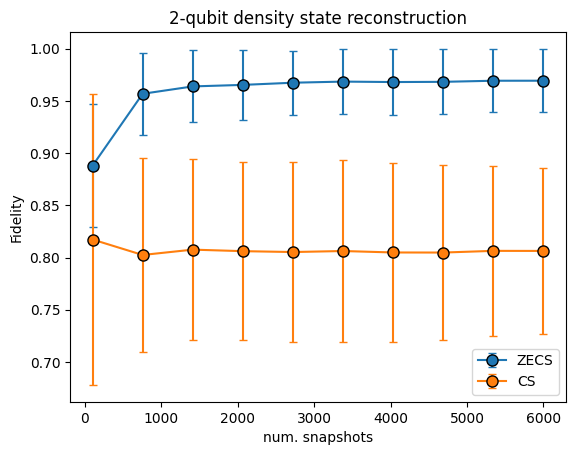

In [11]:
data_zecs = np.array([results["postprocessing"][tuple(system)]["ZECS"]["F"] for system in results["list_2q"]])
data_cs = np.array([results["postprocessing"][tuple(system)]["CS"]["F"] for system in results["list_2q"]])
fig, ax = plt.subplots()
ax.errorbar(results["postprocessing"]["snapshots"],data_zecs.mean(axis=0), data_zecs.std(axis=0), marker="o", capsize=3, markersize=8, markeredgecolor="black", label="ZECS")
ax.errorbar(results["postprocessing"]["snapshots"],data_cs.mean(axis=0), data_cs.std(axis=0), marker="o", capsize=3, markersize=8, markeredgecolor="black", label="CS")
ax.legend()
ax.set_ylabel("Fidelity")
ax.set_xlabel("num. snapshots")
ax.set_title("2-qubit density state reconstruction")

## Layout entanglement entropy plot
The figure below shows the entanglement entropy, $S_{ij}$, of the different subsystems. Edges are associated with 3-qubit and 4-qubit subsystems. The entanglement entropy, $S_{ij}$, between the subsystems indicates that there is a leak of information between subsystems. In the ideal case, $S_{ij}=0$ because the subsystems are not interacting. Furthermore, information of the fidelity and the entanglement entropy seems to be correlated, i.e., in regions where there is low fidelity, the subsystems have high $S_{ij}$. But the region with the worst fidelity, (68,69) is not the region with the highest $S_{ij}$. In the lower part of ibm\_brisbane, there is higher entanglement entropy in qubits 104, 105, 110, 118, 121, and 122. 

In [12]:
layout_pos = { 0:(0,0), 1:(0,1), 2:(0,2), 3:(0,3), 4:(0,4), 5:(0,5), 6:(0,6), 7:(0,7), 8:(0,8), 9:(0,9), 10:(0,10), 11:(0,11), 12:(0,12), 13:(0,13),
14:(1,0), 15:(1,4), 16:(1,8), 17:(1,12),
18:(2,0), 19:(2,1), 20:(2,2), 21:(2,3), 22:(2,4), 23:(2,5), 24:(2,6), 25:(2,7), 26:(2,8), 27:(2,9), 28:(2,10), 29:(2,11), 30:(2,12), 31:(2,13), 32:(2,14),
33:(3,2), 34:(3,6), 35:(3,10), 36:(3,14),
37:(4,0), 38:(4,1), 39:(4,2), 40:(4,3), 41:(4,4), 42:(4,5), 43:(4,6), 44:(4,7), 45:(4,8), 46:(4,9), 47:(4,10), 48:(4,11), 49:(4,12), 50:(4,13), 51:(4,14),
52:(5,0), 53:(5,4), 54:(5,8), 55:(5,12),
56:(6,0), 57:(6,1), 58:(6,2), 59:(6,3), 60:(6,4), 61:(6,5), 62:(6,6), 63:(6,7), 64:(6,8), 65:(6,9), 66:(6,10), 67:(6,11), 68:(6,12), 69:(6,13), 70:(6,14),
71:(7,2), 72:(7,6), 73:(7,10), 74 :(7,14),
75:(8,0), 76:(8,1), 77:(8,2), 78:(8,3), 79:(8,4), 80:(8,5), 81:(8,6), 82:(8,7), 83:(8,8), 84:(8,9), 85:(8,10), 86:(8,11), 87:(8,12), 88:(8,13), 89:(8,14),
90:(9,0), 91:(9,4), 92:(9,8), 93:(9,12),
94:(10,0), 95:(10,1), 96:(10,2), 97:(10,3), 98:(10,4), 99:(10,5), 100:(10,6), 101:(10,7), 102:(10,8), 103:(10,9), 104:(10,10), 105:(10,11), 106:(10,12), 107:(10,13), 108:(10,14),
109:(11,2), 110:(11,6), 111:(11,10), 112:(11,14),
113:(12,1), 114:(12,2), 115:(12,3), 116:(12,4), 117:(12,5), 118:(12,6), 119:(12,7), 120:(12,8), 121:(12,9), 122:(12,10), 123:(12,11), 124:(12,12), 125:(12,13), 126:(12,14),
}
pos = [[i[1],-i[0]] for i in layout_pos.values()]


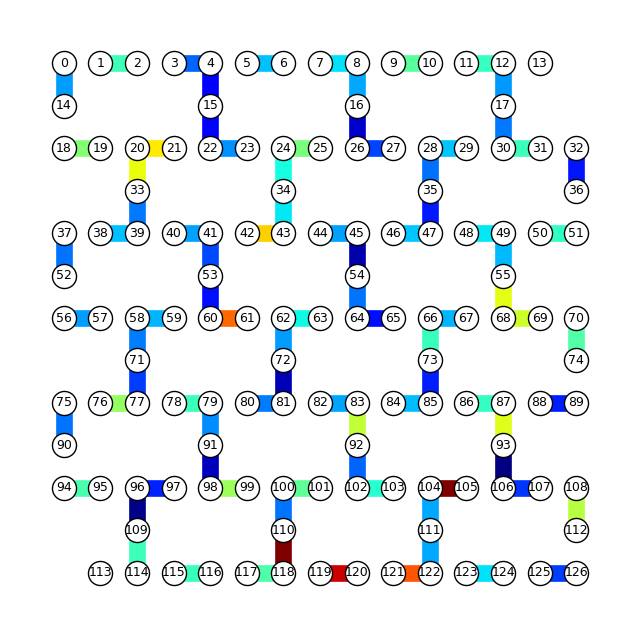

In [13]:
colors = plt.get_cmap("jet")

G = nx.Graph()
G.add_nodes_from(range(127))

s_3q = {tuple(system): results["postprocessing"][tuple(system)]["ZECS"]["Sab"] for system in results["list_3q"]}
s_4q = {tuple(system): results["postprocessing"][tuple(system)]["ZECS"]["Sab"] for system in results["list_4q"]}

max_3q = max(s_3q.values())
max_4q = max(s_4q.values())

for qubits in s_3q.keys():
    G.add_weighted_edges_from([[qubits[1],qubits[2],s_3q[qubits]/max_3q]])
for qubits in s_4q.keys():
    G.add_weighted_edges_from([[qubits[1],qubits[2],s_4q[qubits]/max_4q]])

weights = np.array([G[i][j]["weight"] for i, j in G.edges])
norm_weights = (weights - weights.min())/(weights.max() - weights.min())
edge_colors = [colors(w) for w in norm_weights]
fig, ax = plt.subplots(figsize=(8,8))
nx.draw(G, pos=pos, ax=ax, font_size=9, edgecolors="black", width=12, edge_color=edge_colors, node_color="white",with_labels=True)

# Non-local crosstalk detection

In [14]:
systems_of_interest = [[19,20],[67,68],[103,104],[119,118],[59,60]]
results["crosstalk"] = {}
for case_interest in systems_of_interest:
    results["crosstalk"][tuple(case_interest)] = {}
    for system in results["list_2q"]:
        systems = tuple(system + case_interest)
        system = tuple(system)
        results["crosstalk"][tuple(case_interest)][system] = {}
        print(f"------------      System      {system}    ----------------")
        results["crosstalk"][tuple(case_interest)][system]["p0"] = np.kron(results["pideal"][system], results["pideal"][tuple(case_interest)])
        rho_cs = shadow_state_reconstruction(results["snapshots"], results["random_unitaries"], list_qubits=systems)
        sv_zecs = zecs(rho_cs)
        rho_zecs = sv_zecs @ sv_zecs.T.conj()
        results["crosstalk"][tuple(case_interest)][system]["p"] = rho_zecs
        results["crosstalk"][tuple(case_interest)][system]["Sab"] = entropy(partial_trace(rho_zecs, [0, 1]))
np.save(f"./Data/{backend_name}/shadows_EfficientSU2_{reps}.npy", results)
 

------------      System      (13, 12)    ----------------
------------      System      (11, 10)    ----------------
------------      System      (9, 8)    ----------------
------------      System      (7, 6)    ----------------
------------      System      (5, 4)    ----------------
------------      System      (3, 2)    ----------------
------------      System      (1, 0)    ----------------
------------      System      (14, 18)    ----------------
------------      System      (19, 20)    ----------------
------------      System      (21, 22)    ----------------
------------      System      (23, 24)    ----------------
------------      System      (25, 26)    ----------------
------------      System      (27, 28)    ----------------
------------      System      (29, 30)    ----------------
------------      System      (31, 32)    ----------------
------------      System      (36, 51)    ----------------
------------      System      (50, 49)    ----------------
-------

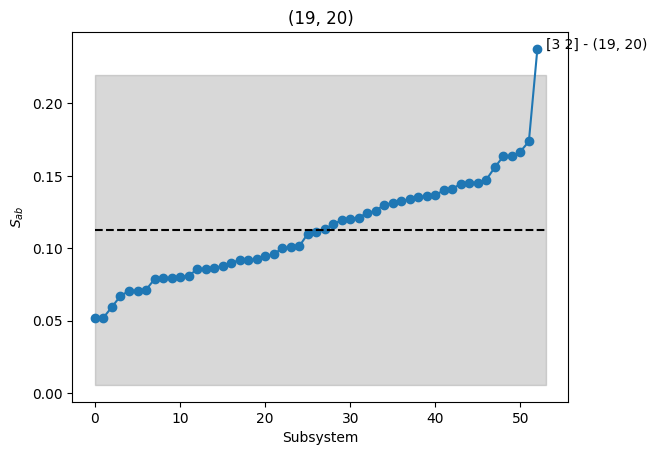

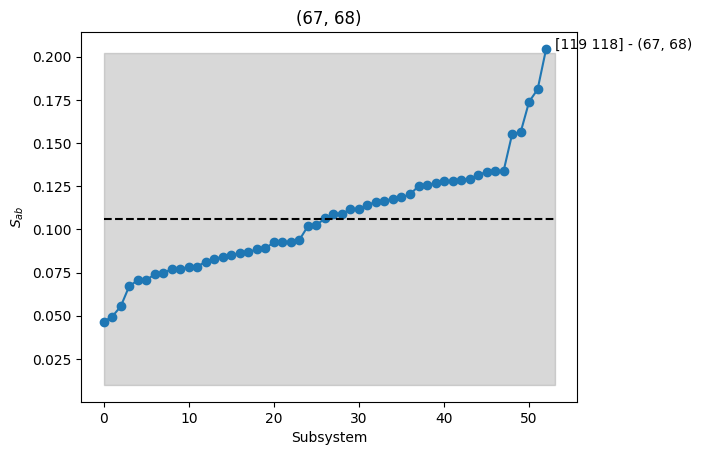

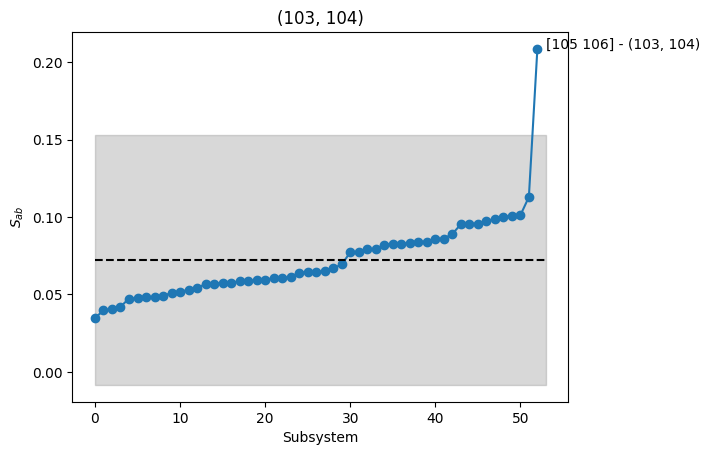

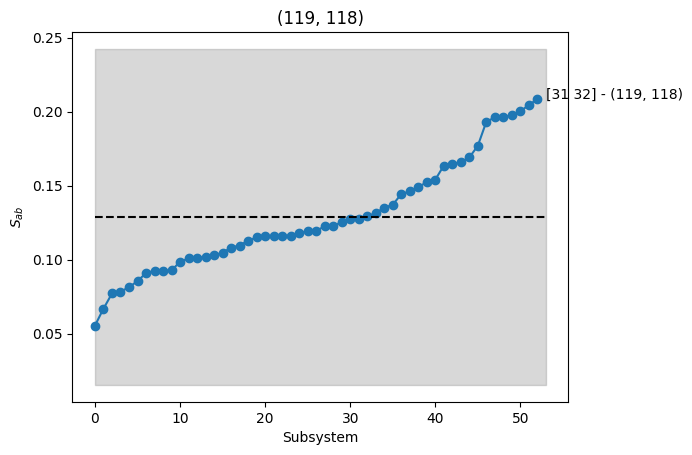

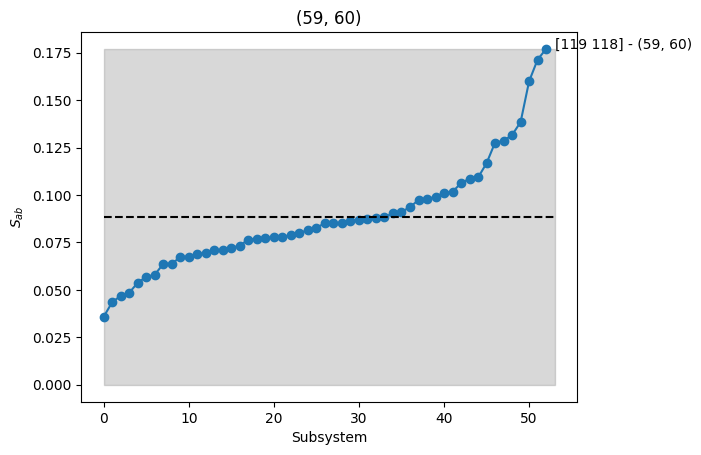

In [15]:
for case_interest in systems_of_interest:
    case_interest = tuple(case_interest)
    S = np.array([results["crosstalk"][case_interest][tuple(system)]["Sab"] for system in results["list_2q"] if tuple(system) != case_interest])
    list_2q = np.array([system for system in results["list_2q"] if tuple(system) != case_interest])

    arg_max = np.argmax(S)
    fig, ax = plt.subplots()
    ax.plot(np.sort(S), marker="o")
    ax.fill_between([0, len(S)], 2*[S.mean() - 3*S.std()], 2*[S.mean() + 3*S.std()], color="grey", alpha=0.3)
    ax.plot([0, len(S)], 2*[np.mean(S)], linestyle="--", color="black", label="mean")
    ax.set_ylabel(r"$S_{ab}$")
    ax.set_xlabel("Subsystem")
    ax.text(len(S), S[arg_max], f"{list_2q[arg_max]} - {case_interest}")
    ax.set_title(case_interest)
